# Setup

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from water import data
from water.names import BEACHES
from water.viz import plot_exceedances, plot_all_years_site

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(13, 9), 'figure.max_open_warning': 50})
sns.set_context('talk')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = data.load()

# Beach time series

Let's first look at a time series of each beach, showing when it was over the 1000 MPN/100 mL of *E. coli* used by Public Health Madison & Dane County (PHMDC) to close beaches.

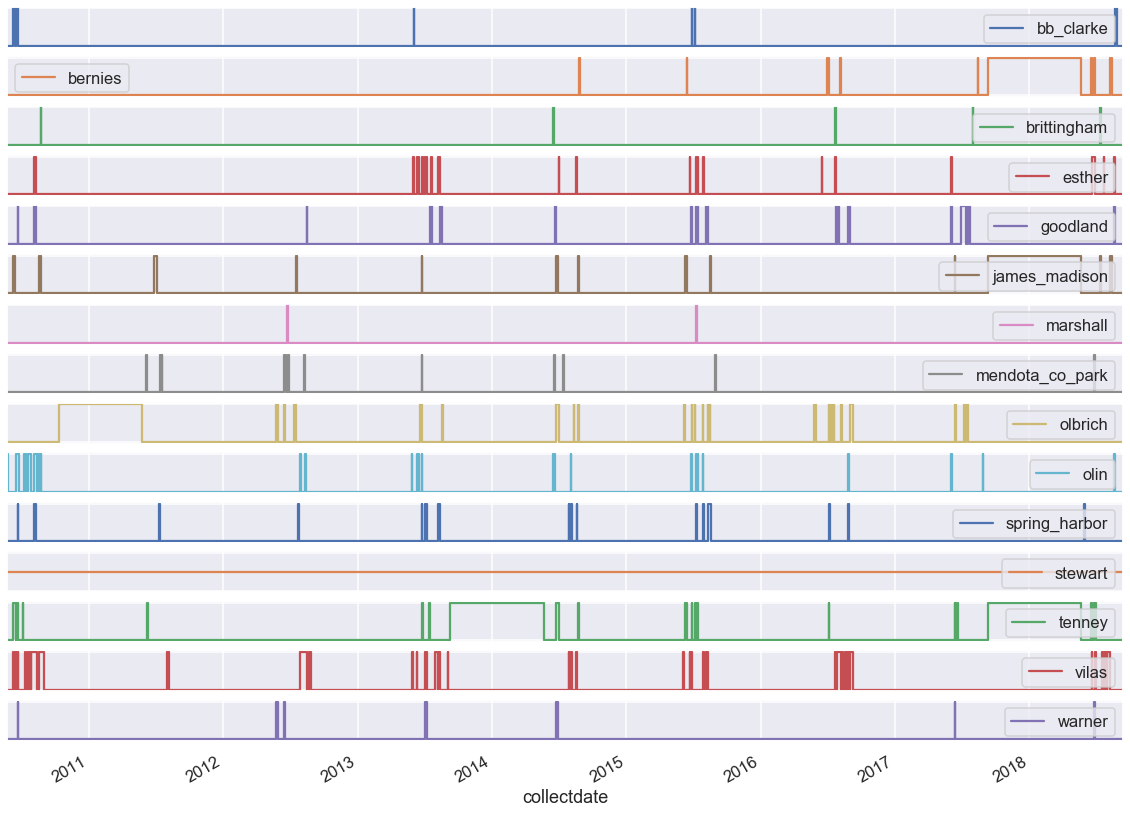

In [3]:
axs = (df[BEACHES] > 1000).astype(float).plot(subplots=True, figsize=(20, 15), drawstyle='steps')
for ax in axs:
    ax.set_yticklabels([])

Now we can focus in on a few beaches that look like they might be interesting based off the above plot.

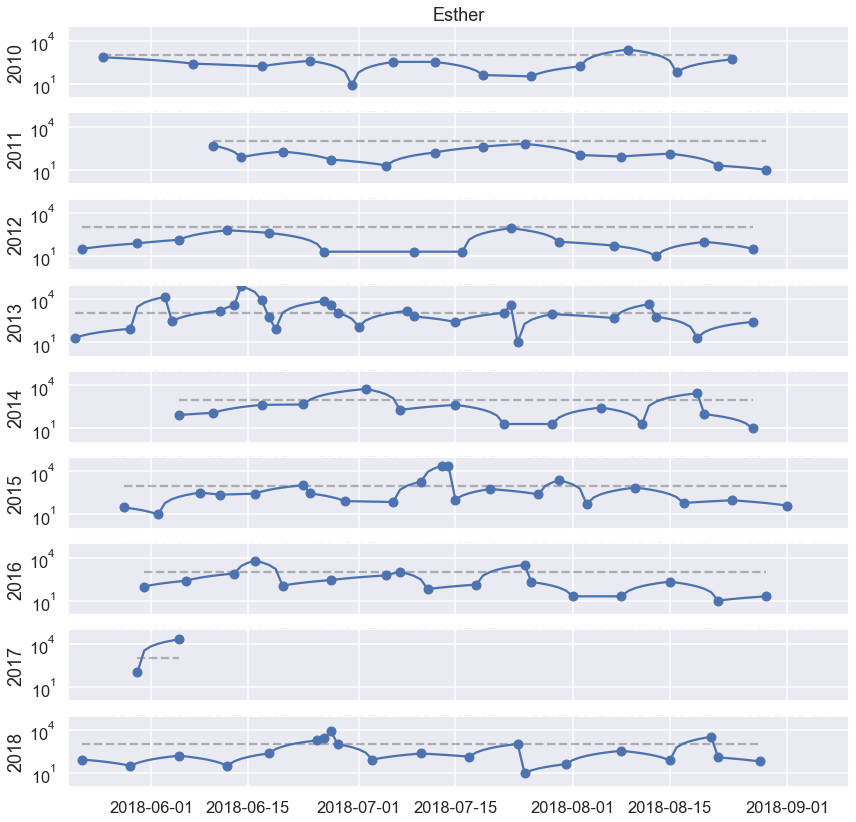

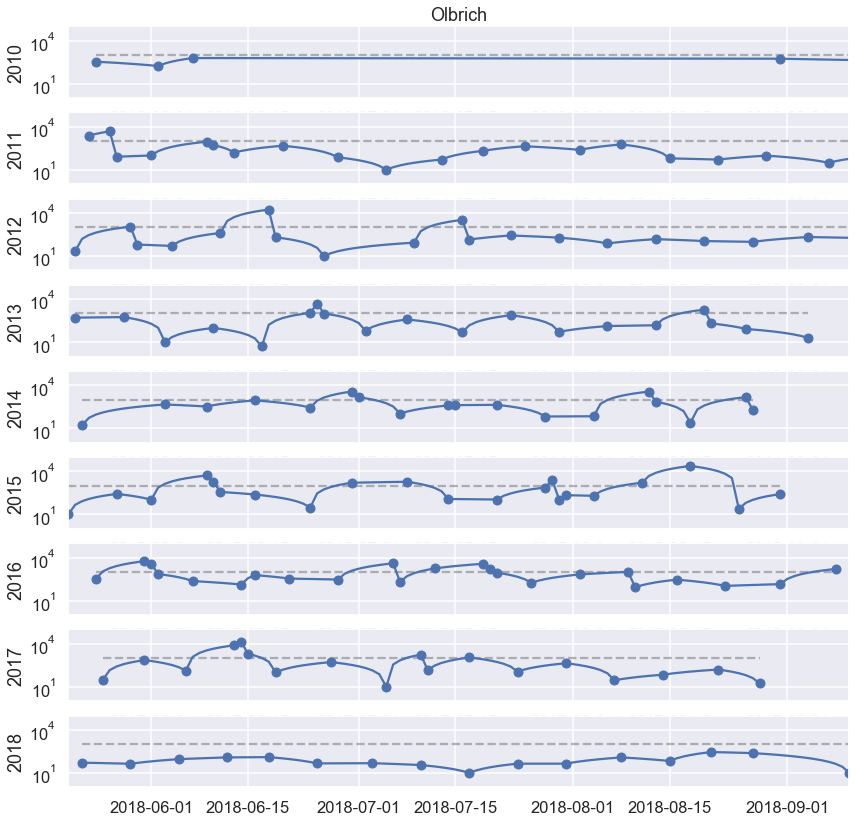

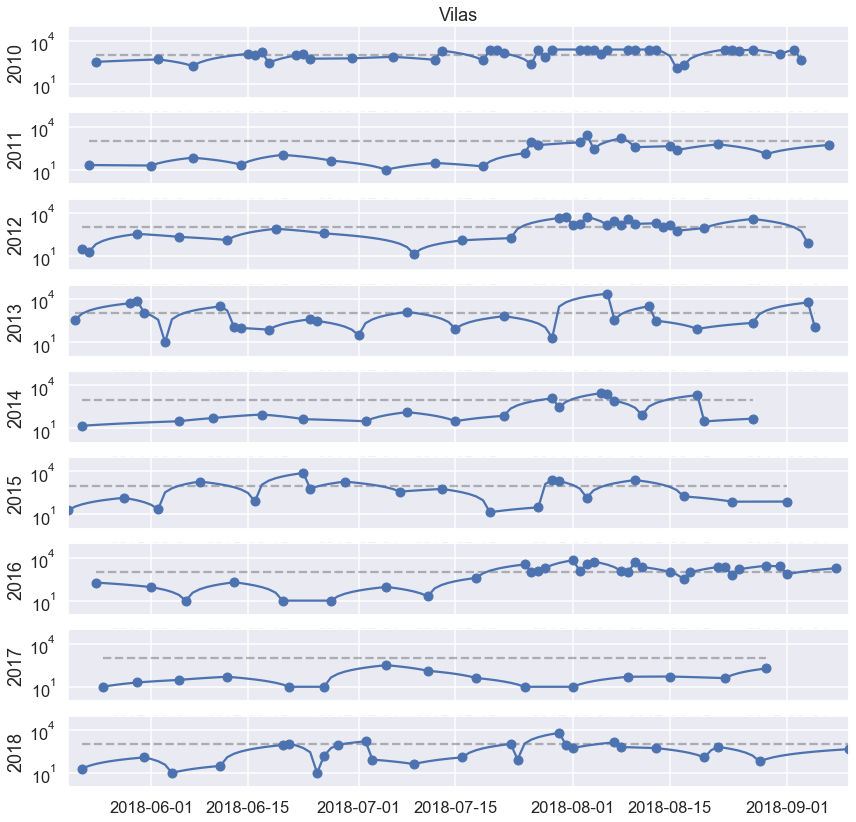

In [4]:
for site in ['esther', 'olbrich', 'vilas']:
    plot_all_years_site(df, site)

# Exceedances

We're specifically curious about beach "exceedances", or the periods of time when a beach's readings are above the closure threshold.

Let's look at each exceedance period for each beach. The first reading that is above the threshold will count as day 0, then we'll plot each reading until the first reading that is back below the threshold. Exceecances that go across years are ignored.

Start with the beaches that don't have any long exceedances (> 8 days).

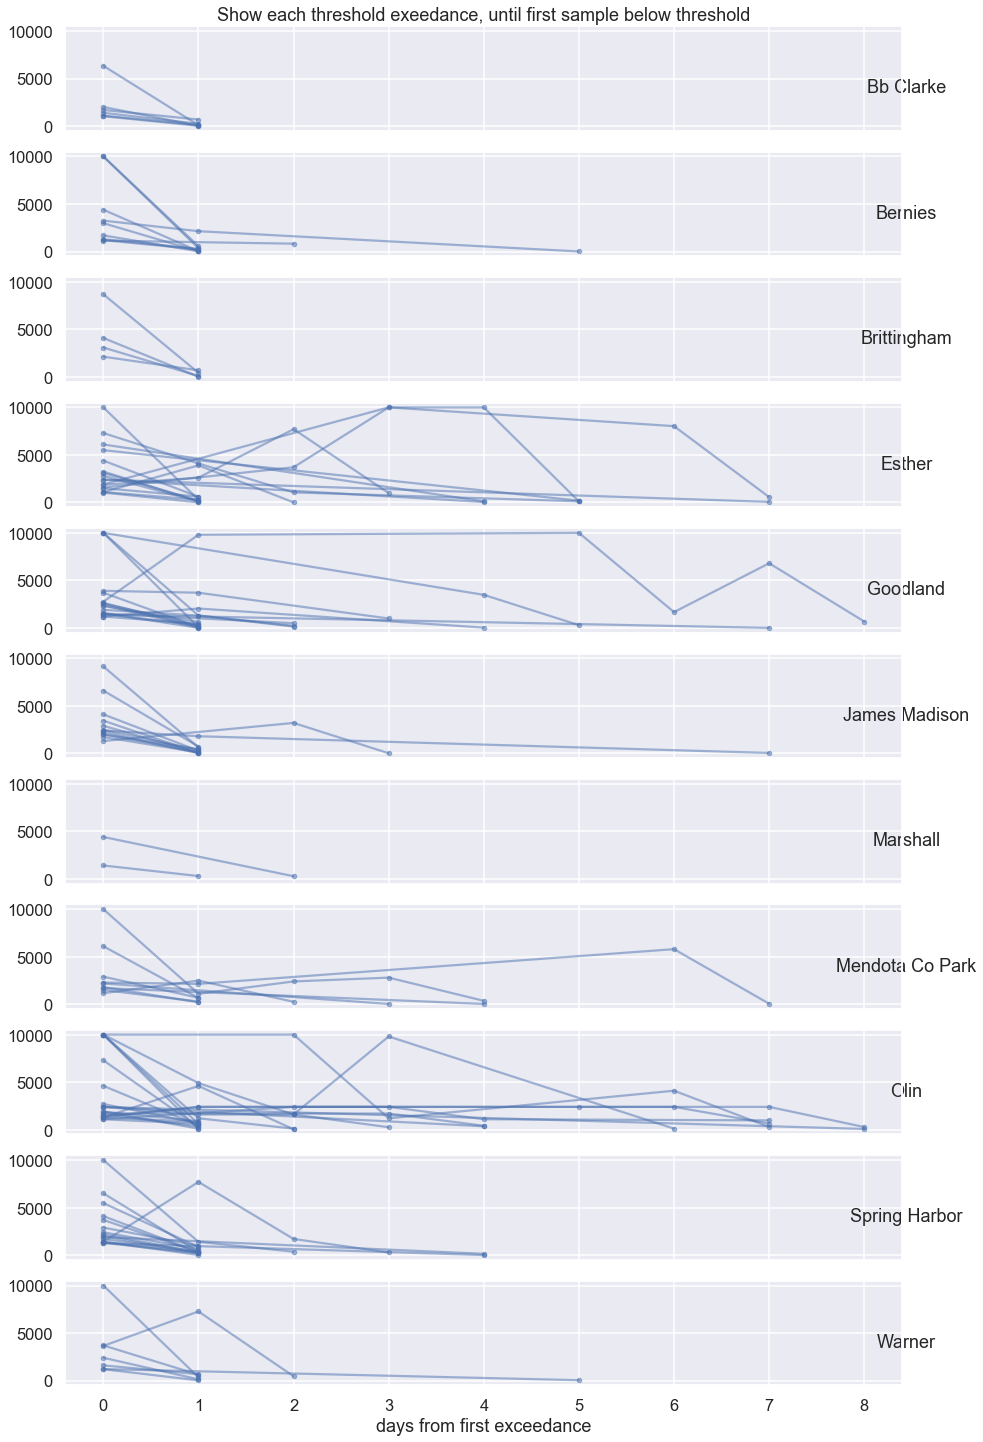

In [5]:
sites_to_show = []
for site in BEACHES:
    if (
        df[site].notna().sum() > 30
        and (df[site] > 1000).sum() > 1
        and site not in ['olbrich', 'vilas', 'tenney']
    ):
        sites_to_show.append(site)

_, axs = plt.subplots(len(sites_to_show), sharex=True, sharey=True, figsize=(15, 25))
for ax, site in zip(axs, sites_to_show):
    plot_exceedances(df, site, ax)
axs[0].set_title('Show each threshold exeedance, until first sample below threshold')
axs[-1].set_xlabel('days from first exceedance');

And then the three beaches with long exceedances (> 8 days).

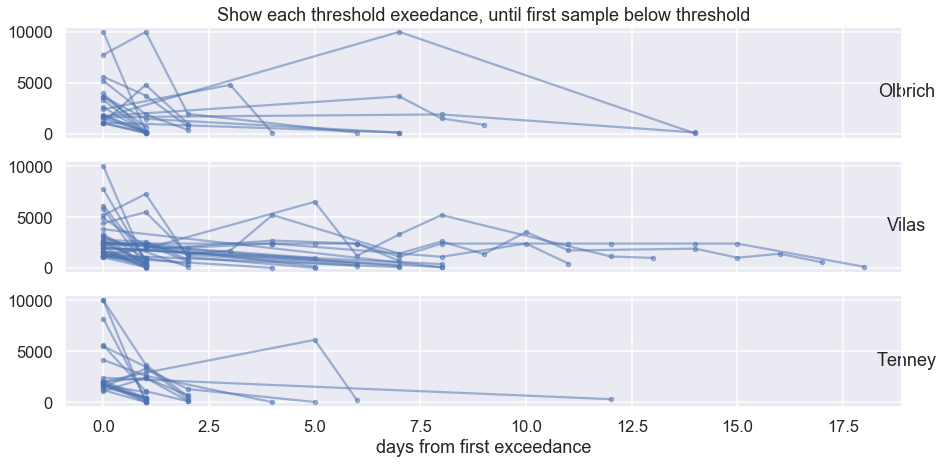

In [6]:
sites_to_show = ['olbrich', 'vilas', 'tenney']
_, axs = plt.subplots(len(sites_to_show), sharex=True, sharey=True, figsize=(15, 7))
for ax, site in zip(axs, sites_to_show):
    plot_exceedances(df, site, ax)
axs[0].set_title('Show each threshold exeedance, until first sample below threshold')
axs[-1].set_xlabel('days from first exceedance');

## Probability of a 1-day exceedance

And finally, let's look at the probability for each beach that the exceedance will last only one day.

This will be useful as a rule of thumb to know when it may make sense to sample a beach with the quicker, but more expensive, qPCR method.

In [7]:
mean_exceedance_lengths = {}
for site_name in BEACHES:
    lengths = []
    site_df = df[site_name].dropna()
    for year in site_df.index.year.unique():
        site_year_df = site_df[(site_df.index >= str(year)) & (site_df.index < str(year + 1))]
        in_exceedance = False
        for i in range(site_year_df.shape[0]):
            if in_exceedance:
                if site_year_df.iloc[i] < 1000:
                    in_exceedance = False
                    lengths.append((site_year_df.index[i] - start_date).days)
            if site_year_df.iloc[i] >= 1000:
                in_exceedance = True
                start_date = site_year_df.index[i]
    if not lengths:
        print(site_name, 'has no exceedances.')
        continue
    num_equal_1 = sum([l == 1 for l in lengths])
    mean_exceedance_lengths[site_name] = [
        num_equal_1 / len(lengths),
        np.mean(lengths),
        len(lengths)
    ]

(
    pd.DataFrame(mean_exceedance_lengths)
    .T
    .rename(columns={0: 'prob(done after 1)', 1: 'mean exceedance interval', 2: 'n'})
    .sort_values(by=['prob(done after 1)'], ascending=False)
)

stewart has no exceedances.


,prob(done after 1),mean exceedance interval,n
bb_clarke,1.000000,1.000000,6.0
brittingham,1.000000,1.000000,4.0
james_madison,0.916667,1.416667,12.0
spring_harbor,0.875000,1.375000,16.0
warner,0.857143,1.571429,7.0
tenney,0.842105,1.789474,19.0
olin,0.809524,1.666667,21.0
bernies,0.777778,1.444444,9.0
mendota_co_park,0.777778,1.555556,9.0
goodland,0.764706,1.588235,17.0
